In [1]:
!pip install -q kaggle

In [2]:
# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d virajinduruwa/real-vs-fakeai-image-dataset

Dataset URL: https://www.kaggle.com/datasets/virajinduruwa/real-vs-fakeai-image-dataset
License(s): apache-2.0
 98% 284M/291M [00:00<00:00, 866MB/s] 
100% 291M/291M [00:00<00:00, 917MB/s]


In [4]:
import zipfile

zip_ref = zipfile.ZipFile('/content/real-vs-fakeai-image-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import cv2
import shutil
import warnings
warnings.filterwarnings('ignore')

print("Libraries Imported Successfully!")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

Libraries Imported Successfully!
TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
class Config:
    # Dataset paths - adjusted for new structure
    BASE_DIR = '/content/content'
    FAKE_DIR = '/content/content/fake_images'
    REAL_DIR = '/content/content/real_images'

    # Organized dataset paths (will be created)
    ORGANIZED_DIR = '/content/organized_dataset'
    TRAIN_DIR = '/content/organized_dataset/train'
    TEST_DIR = '/content/organized_dataset/test'
    VAL_DIR = '/content/organized_dataset/val'

    # Model parameters
    IMG_SIZE = (256, 256)
    BATCH_SIZE = 32
    EPOCHS = 25

    # Train/Val/Test split
    TRAIN_SPLIT = 0.8
    TEST_SPLIT = 0.1
    VAL_SPLIT = 0.1

    # Class names
    CLASS_NAMES = ['fake', 'real']

    # Model save paths
    MODEL_H5_PATH = 'cnn_image_classifier.keras'
    MODEL_TFLITE_PATH = 'cnn_image_classifier.tflite'

config = Config()
print("Configuration loaded successfully")

Configuration loaded successfully


In [8]:
import os
import glob
import shutil
import numpy as np
from pathlib import Path

def reorganize_dataset():
    """
    Reorganize the dataset into train/val/test splits with fake/real subdirectories
    """
    print("Reorganizing dataset structure...")

    # Create directories
    for split in ['train', 'val', 'test']:
        for class_name in ['fake', 'real']:
            os.makedirs(os.path.join(config.ORGANIZED_DIR, split, class_name), exist_ok=True)

    # Collect all fake images from subdirectories
    print("\nCollecting fake images from all generation models...")
    fake_images = []
    fake_subdirs = [d for d in os.listdir(config.FAKE_DIR)
                    if os.path.isdir(os.path.join(config.FAKE_DIR, d))]

    print(f"Found {len(fake_subdirs)} generation models:")
    for subdir in fake_subdirs:
        subdir_path = os.path.join(config.FAKE_DIR, subdir)
        images = glob.glob(os.path.join(subdir_path, '*.*'))
        images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        fake_images.extend(images)
        print(f"  - {subdir}: {len(images)} images")

    print(f"\nTotal fake images: {len(fake_images)}")

    # Collect all real images
    print("\nCollecting real images...")
    real_images = glob.glob(os.path.join(config.REAL_DIR, '*.*'))
    real_images = [img for img in real_images if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    print(f"Total real images: {len(real_images)}")

    # Split fake images
    np.random.seed(42)
    np.random.shuffle(fake_images)

    n_fake = len(fake_images)
    train_fake_end = int(n_fake * config.TRAIN_SPLIT)
    val_fake_end = train_fake_end + int(n_fake * config.VAL_SPLIT)

    fake_train = fake_images[:train_fake_end]
    fake_val = fake_images[train_fake_end:val_fake_end]
    fake_test = fake_images[val_fake_end:]

    # Split real images
    np.random.shuffle(real_images)

    n_real = len(real_images)
    train_real_end = int(n_real * config.TRAIN_SPLIT)
    val_real_end = train_real_end + int(n_real * config.VAL_SPLIT)

    real_train = real_images[:train_real_end]
    real_val = real_images[train_real_end:val_real_end]
    real_test = real_images[val_real_end:]

    # Copy files to organized structure
    print("\nCopying files to organized structure...")

    def copy_images(image_list, split, class_name):
        dest_dir = os.path.join(config.ORGANIZED_DIR, split, class_name)
        for i, src in enumerate(image_list):
            ext = os.path.splitext(src)[1]
            dest = os.path.join(dest_dir, f"{class_name}_{i:06d}{ext}")
            shutil.copy2(src, dest)

    print("Copying training images...")
    copy_images(fake_train, 'train', 'fake')
    copy_images(real_train, 'train', 'real')

    print("Copying validation images...")
    copy_images(fake_val, 'val', 'fake')
    copy_images(real_val, 'val', 'real')

    print("Copying test images...")
    copy_images(fake_test, 'test', 'fake')
    copy_images(real_test, 'test', 'real')

    # Print summary
    print("\n" + "="*60)
    print("DATASET REORGANIZATION COMPLETE")
    print("="*60)
    print(f"Training set:   {len(fake_train)} fake + {len(real_train)} real = {len(fake_train) + len(real_train)} total")
    print(f"Validation set: {len(fake_val)} fake + {len(real_val)} real = {len(fake_val) + len(real_val)} total")
    print(f"Test set:       {len(fake_test)} fake + {len(real_test)} real = {len(fake_test) + len(real_test)} total")
    print("="*60)

# Run reorganization
reorganize_dataset()

Reorganizing dataset structure...

Found 23 generation models:
  - projected_gan: 1000 images
  - gansformer: 500 images
  - latent_diffusion: 500 images
  - gau_gan: 1000 images
  - denoising_diffusion_gan: 500 images
  - palette: 500 images
  - face_synthetics: 500 images
  - diffusion_gan: 500 images
  - vq_diffusion: 500 images
  - generative_inpainting: 1000 images
  - stylegan2: 851 images
  - sfhq: 500 images
  - glide: 500 images
  - stylegan1: 1000 images
  - lama: 500 images
  - stylegan3: 500 images
  - ddpm: 149 images
  - taming_transformer: 500 images
  - big_gan: 500 images
  - stable_diffusion: 500 images
  - star_gan: 500 images
  - mat: 500 images
  - cips: 500 images

Total fake images: 13500

Total real images: 11500

Copying files to organized structure...
Copying training images...
Copying validation images...
Copying test images...

DATASET REORGANIZATION COMPLETE
Training set:   10800 fake + 9200 real = 20000 total
Validation set: 1350 fake + 1150 real = 2500 to

In [9]:
train_ds = keras.utils.image_dataset_from_directory(
    directory=config.TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    batch_size=config.BATCH_SIZE,
    image_size=config.IMG_SIZE
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory=config.VAL_DIR,
    labels='inferred',
    label_mode='int',
    batch_size=config.BATCH_SIZE,
    image_size=config.IMG_SIZE
)

test_ds = keras.utils.image_dataset_from_directory(
    directory=config.TEST_DIR,
    labels='inferred',
    label_mode='int',
    batch_size=config.BATCH_SIZE,
    image_size=config.IMG_SIZE,
    shuffle=False
)

Found 20000 files belonging to 2 classes.
Found 2500 files belonging to 2 classes.
Found 2500 files belonging to 2 classes.


In [10]:
# Normalize
def process(image, label):
  image = tf.cast(image/255.0, tf.float32)
  return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)
test_ds = test_ds.map(process)

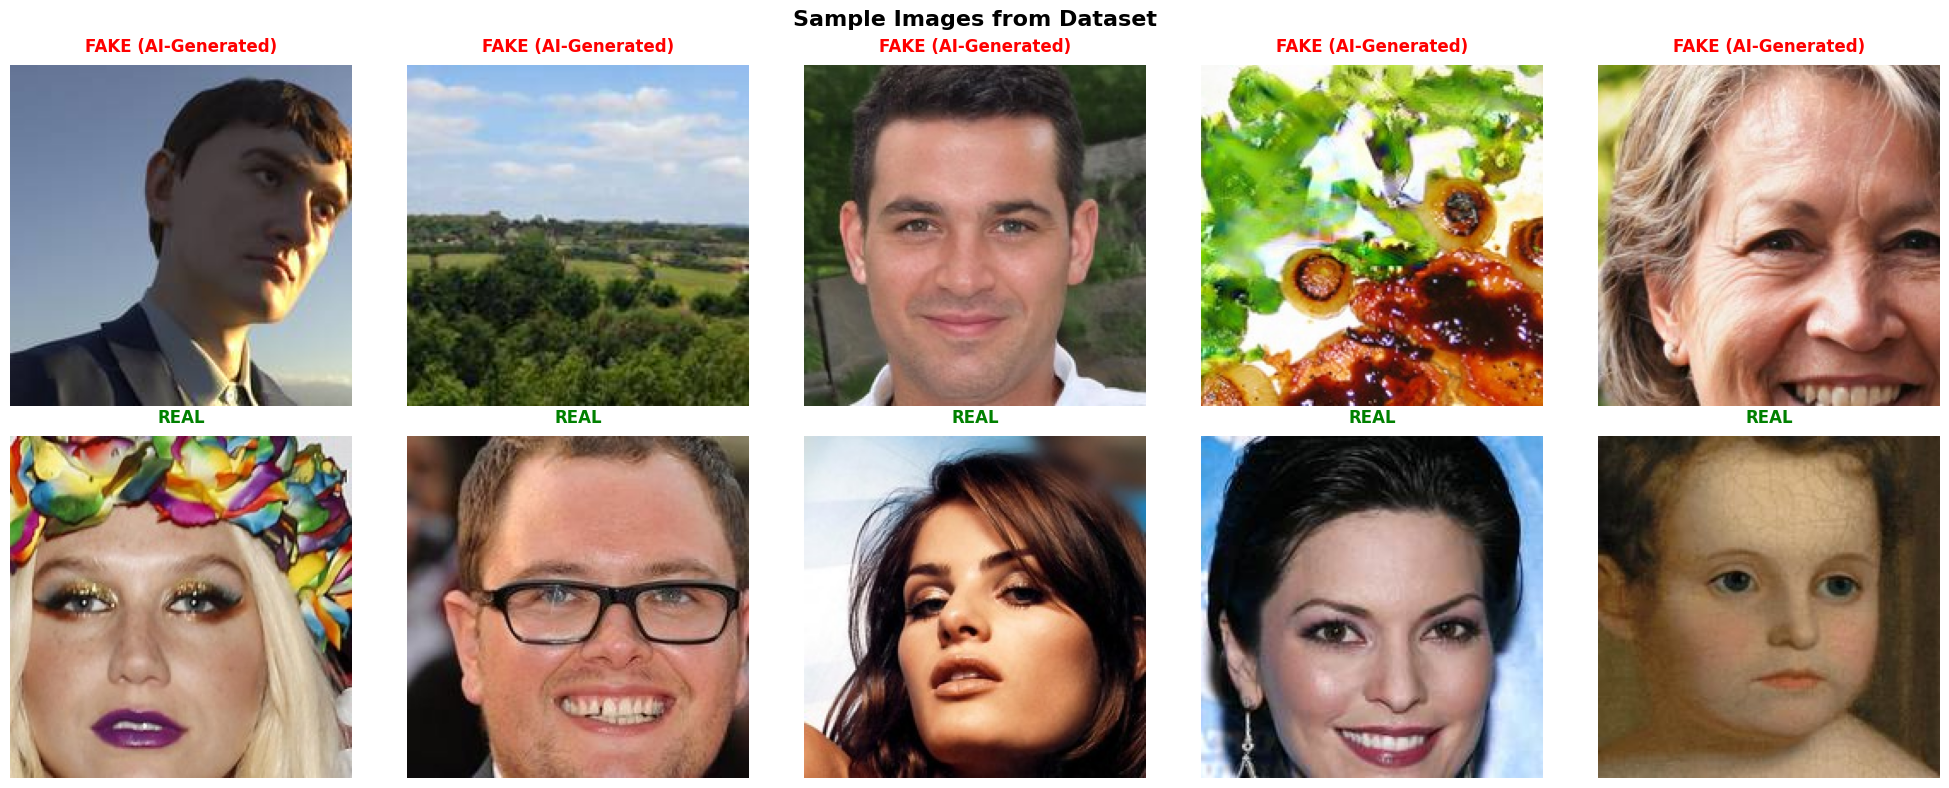

Sample images visualization saved to 'sample_images.png'


In [11]:
# Fake images labeled in RED, Real images labeled in GREEN
import matplotlib.pyplot as plt

def visualize_sample_images(num_samples=5):

    fake_dir = os.path.join(config.TRAIN_DIR, 'fake')
    real_dir = os.path.join(config.TRAIN_DIR, 'real')

    # Get sample images
    fake_images = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir)
                   if f.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp'))][:num_samples]
    real_images = [os.path.join(real_dir, f) for f in os.listdir(real_dir)
                   if f.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp'))][:num_samples]

    # Create figure
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))

    # Plot fake images (top row)
    for i, img_path in enumerate(fake_images):
        img = plt.imread(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title('FAKE (AI-Generated)',
                            fontsize=12,
                            fontweight='bold',
                            color='red',
                            pad=10)
        axes[0, i].axis('off')
        # Add red border
        for spine in axes[0, i].spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(3)
            spine.set_visible(True)

    # Plot real images (bottom row)
    for i, img_path in enumerate(real_images):
        img = plt.imread(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title('REAL',
                            fontsize=12,
                            fontweight='bold',
                            color='green',
                            pad=10)
        axes[1, i].axis('off')
        # Add green border
        for spine in axes[1, i].spines.values():
            spine.set_edgecolor('green')
            spine.set_linewidth(3)
            spine.set_visible(True)

    plt.suptitle('Sample Images from Dataset',
                fontsize=16,
                fontweight='bold',
                y=0.98)
    plt.tight_layout()
    plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Sample images visualization saved to 'sample_images.png'")

# Run visualization
visualize_sample_images(num_samples=5)

In [12]:
# Create CNN Model
model = Sequential()

# Block 1
model.add(Conv2D(32, (3,3), activation='relu', padding='same',
                 kernel_initializer='he_normal', kernel_regularizer=l2(0.001),
                 input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(64, (3,3), activation='relu', padding='same',
                 kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

# Block 3
model.add(Conv2D(128, (3,3), activation='relu', padding='same',
                 kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.4))

# Block 4
model.add(Conv2D(256, (3,3), activation='relu', padding='same',
                 kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.4))

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Dense Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    config.MODEL_H5_PATH.replace('.h5', '.keras'),
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

In [16]:
history = model.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=validation_ds,
    callbacks=[checkpoint, lr_schedule]
)

Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6209 - loss: 1.4754
Epoch 1: val_accuracy improved from -inf to 0.58400, saving model to cnn_image_classifier.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 98ms/step - accuracy: 0.6210 - loss: 1.4751 - val_accuracy: 0.5840 - val_loss: 1.3007 - learning_rate: 5.0000e-04
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7494 - loss: 0.8586
Epoch 2: val_accuracy improved from 0.58400 to 0.75240, saving model to cnn_image_classifier.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 92ms/step - accuracy: 0.7494 - loss: 0.8584 - val_accuracy: 0.7524 - val_loss: 0.6978 - learning_rate: 5.0000e-04
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7909 - loss: 0.6446
Epoch 3: val_accuracy improved from 0.75240 to 0.75840, saving model to cnn_image_classifier.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 92ms/step - accuracy: 0.7910 - loss: 0.6446 - val_accuracy: 0.7584 - val_loss: 0.6485 - learning_rate: 5.0000e-04
Epoc

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Ensure test dataset is not shuffled
test_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Get predictions
pred_probs = model.predict(test_ds)
pred_classes = (pred_probs > 0.5).astype("int32").flatten()

# Basic Metrics
acc = accuracy_score(test_labels, pred_classes)
prec = precision_score(test_labels, pred_classes)
rec = recall_score(test_labels, pred_classes)
f1 = f1_score(test_labels, pred_classes)
auc = roc_auc_score(test_labels, pred_probs)

print("MODEL PERFORMANCE")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
MODEL PERFORMANCE
Accuracy:  0.8504
Precision: 0.8374
Recall:    0.8374
F1 Score:  0.8374
AUC Score: 0.9239


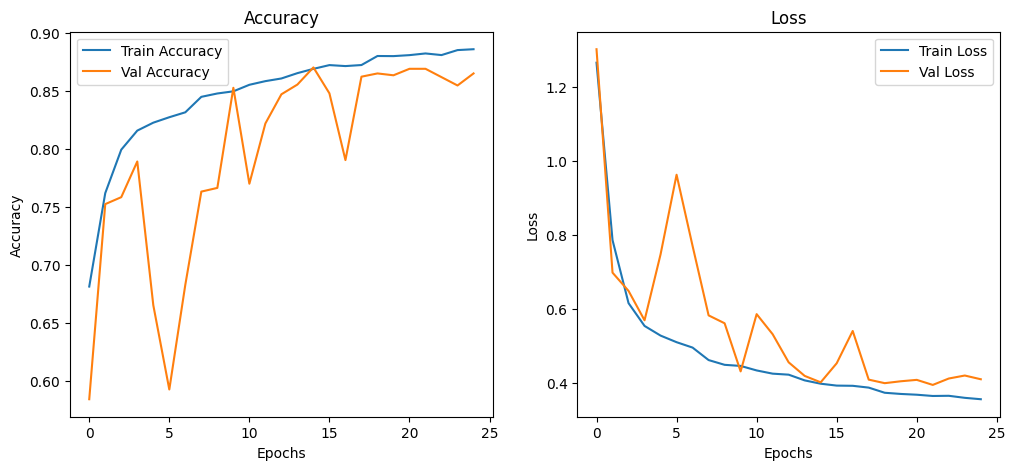

In [21]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss")

plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


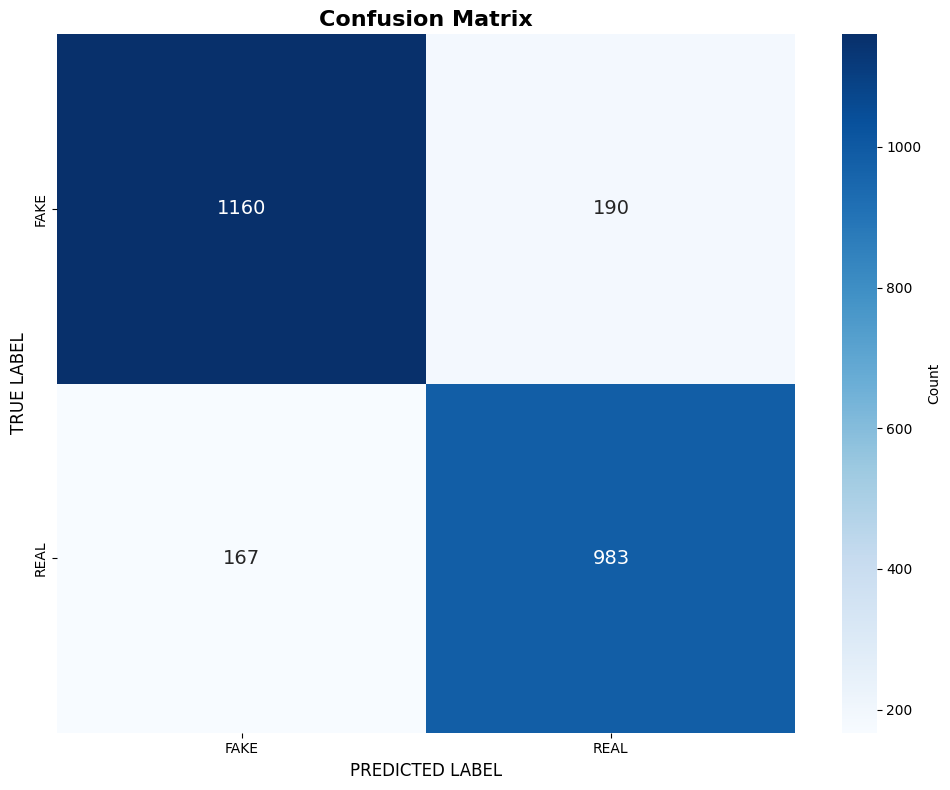

Confusion matrix saved to 'confusion_matrix.png'

Confusion Matrix Values:
True Negatives:  1160
False Positives: 190
False Negatives: 167
True Positives:  983


In [33]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Confusion Matrix
# Extract true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Predictions
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert class names to UPPERCASE
upper_class_names = [name.upper() for name in config.CLASS_NAMES]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=upper_class_names,
    yticklabels=upper_class_names,
    cbar_kws={'label': 'Count'},
    annot_kws={'size': 14}
)

plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('TRUE LABEL', fontsize=12)
plt.xlabel('PREDICTED LABEL', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved to 'confusion_matrix.png'")

# Print confusion matrix values
print("\nConfusion Matrix Values:")
print(f"True Negatives:  {cm[0][0]}")
print(f"False Positives: {cm[0][1]}")
print(f"False Negatives: {cm[1][0]}")
print(f"True Positives:  {cm[1][1]}")

In [45]:
# Classification Report
print(classification_report(test_labels, pred_classes, target_names=["Fake", "Real"]))

              precision    recall  f1-score   support

        Fake       0.86      0.86      0.86      1350
        Real       0.84      0.84      0.84      1150

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500



In [29]:
from tensorflow.keras.models import load_model

# Convert the model ino the .h5 method
model = load_model("cnn_image_classifier.keras")
model.save("cnn_image_classifier.h5")

In [34]:
# Convert the Keras model to TensorFlowLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model
with open(config.MODEL_TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to {config.MODEL_TFLITE_PATH}")

# Check model size
h5_size = os.path.getsize(config.MODEL_H5_PATH) / (1024 * 1024)
tflite_size = os.path.getsize(config.MODEL_TFLITE_PATH) / (1024 * 1024)

print(f"\nModel Sizes:")
print(f"Keras Model:     {h5_size:.2f} MB")
print(f"TFLite Model: {tflite_size:.2f} MB")
print(f"Compression:  {((h5_size - tflite_size) / h5_size * 100):.2f}% reduction")

Saved artifact at '/tmp/tmp38_de8zl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132728308923280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132728308922128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132728308920208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132728308920016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132728308923088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132728308920976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132728308920592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132728308915792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132728308921552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132728308918480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132728308919248